# 強化学習カスタム環境の構築

https://juliareinforcementlearning.org/docs/How_to_write_a_customized_environment/

ReinforcementLearning.jl でアルゴリズムを適用するためには、解決したい問題を認識可能な方法で定義する必要がある

ここでは [ReinforcementLearningBase.jl](https://juliareinforcementlearning.org/docs/rlbase/#ReinforcementLearningBase.jl) で定義されたインターフェイスに基づいてさまざまな種類の環境を作成する方法を示す

それに触発されて、Juliaの多重ディスパッチを利用し、マルチエージェント環境をカバーするために、これらのインターフェースを少し拡張します。

## 実装する最小限のインターフェース

強化学習タスクを説明するために最も一般的に使用されるインターフェースは [OpenAI/Gym](https://gym.openai.com/) である

ReinforcementLearningBase.jl はそれに触発されて、Julia の多重ディスパッチを利用したマルチエージェント環境をカバーするデフォルトの実装を行っている

したがってほとんどの場合、カスタマイズされた環境を定義するには、次の関数を実装するだけで済む

```julia
action_space(env::YourEnv)
state(env::YourEnv)
state_space(env::YourEnv)
reward(env::YourEnv)
is_terminated(env::YourEnv)
reset!(env::YourEnv)
(env::YourEnv)(action)
```

## 例: LotteryEnv

まずは、以下のような単純なルールのゲームを考える

- 前提: エージェントは $10 を所持している
- アクション:
    1. PowerRich宝くじを購入する
        - 1%の確率で $100M を獲得し, 99%の確率で $10 を失う
    2. MegaHaul宝くじを購入する
        - 5%の確率で $1M を獲得し, 95%の確率で $10 を失う
    3. 宝くじを買わない

このゲームはワンショットゲームであるため、アクション実行後すぐに終了して報酬を受け取る 

In [1]:
using ReinforcementLearning

"""
    mutable struct LotteryEnv <: AbstractEnv

LotteryEnv の定義: AbstractEnv から継承

- `reward::Union{Nothing, Int}`: 報酬 (初期値: nothing)
"""
# Base.@kwdef を使って struct 定義すると、定義時に値の初期化ができるため便利
Base.@kwdef mutable struct LotteryEnv <: AbstractEnv
    reward::Union{Nothing, Int} = nothing
end

"""
    RLBase.action_space(env::Lottery) ::Tuple

LotteryEnv の行動空間を定義

# Actions

- `:PowerRich`: PowerRich宝くじを購入する
- `:MegaHaul`: MegaHaul宝くじを購入する
- `nothing`: 宝くじを買わない
"""
RLBase.action_space(env::LotteryEnv) = (:PowerRich, :MegaHaul, nothing)

"""
    RLBase.reward(env::LotteryEnv) ::Union{Nothing, Int}

LotteryEnv の報酬を定義: LotteryEnv.reward をそのまま返す
"""
RLBase.reward(env::LotteryEnv) = env.reward

"""
    RLBase.state_space(env::LotteryEnv) ::Vector{Bool}

LotteryEnv の状態空間を定義: ワンショットゲームのため「実行状態」か「終了状態」しかない

# States

- `false`: 実行状態
- `true`: 終了状態
"""
RLBase.state_space(env::LotteryEnv) = [false, true]

"""
    RLBase.state(env::LotteryEnv) ::Bool

LotteryEnv の現在の状態を定義: ワンショットゲームのため「実行状態」か「終了状態」しかない

# Returns

- `false`: 実行状態
- `true`: 終了状態
"""
RLBase.state(env::LotteryEnv) = !isnothing(env.reward)

"""
    RLBase.is_terminated(env::LotteryEnv) ::Bool

LotteryEnv の終了条件を定義: 報酬を受け取ったら終了
"""
RLBase.is_terminated(env::LotteryEnv) = !isnothing(env.reward)

"""
    RLBase.reset!(env::LotteryEnv)

LotteryEnv の初期化処理: 報酬を nothing にする
"""
RLBase.reset!(env::LotteryEnv) = env.reward = nothing

"""
    (env::LotteryEnv)(action)

ゲームロジックの定義

- `action`: RLBase.action_space で定義されたいずれかのアクション
"""
function (env::LotteryEnv)(action)
    if action === :PowerRich
        env.reward = rand() < 0.01 ? 100_000_000 : -10
    elseif action == :MegaHaul
        env.reward = rand() < 0.05 ? 1_000_000 : -10
    elseif isnothing(action)
        env.reward = 0
    else
        @error "unknown action of $action"
    end
end

LotteryEnv

### 環境をテストする
ReinforcementLearningBase.jl では、いくつかのシミュレーションを展開して、定義した環境が機能しているか確認するために `RLBase.test_runnable!` 関数が提供されている

この関数は、単純に以下のようなテストを実行するものである

```julia
for _ in 1:n_episode
    reset!(env)
    while !is_terminated(env)
        # 行動空間からランダムな行動をピックアップしてゲームロジックを実行
        env |> action_space |> rand |> env
    end
end
```

In [2]:
env = LotteryEnv()

# LotteryEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Bool[0, 1]`

## Action Space

`(:PowerRich, :MegaHaul, nothing)`

## Current State

```
false
```


In [3]:
RLBase.test_runnable!(env)

Test Summary:                 | Pass  Total
random policy with LotteryEnv | 2000   2000


Test.DefaultTestSet("random policy with LotteryEnv", Any[], 2000, false, false)

In [4]:
# もう一つ環境テスト:
# - ランダム行動選択ポリシー (RandomPolicy) で 1000 回ゲームを実行
run(
    RandomPolicy(action_space(env)),
    env,
    StopAfterEpisode(1_000),
    TotalRewardPerEpisode()
)

                    ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
                    ┌────────────────────────────────────────┐ 
          100000000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score            │⠴⠤⠤⠤⠤⠶⠤⠤⠤⠤⠦⠤⠤⠤⠦⠶⠴⠴⠴⠤⠤⠦⠶⠧⠤⠤⠤⠶⠤⠦⠴⠤⠤⠤⠤⠤⠦⠴⠴⠦│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

TotalRewardPerEpisode([-10.0, -10.0, -10.0, -10.0, 0.0, -10.0, -10.0, -10.0, 0.0, 0.0  …  -10.0, -10.0, 0.0, 0.0, -10.0, 0.0, -10.0, -10.0, 0.0, -10.0], 0.0, true)

                    ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
                    ┌────────────────────────────────────────┐ 
          100000000 │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢸⠀│ 
                    │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢸⠀│ 
                    │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢸⠀│ 
                    │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢸⠀│ 
                    │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢸⠀│ 
                    │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢸⠀│ 
                    │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢸⠀│ 
   Score            │⠤⠤⠤⠤⠤⠼⠧⠤⠤⠦⠤⠤⠤⠤⠤⠤⠦⠤⠤⠴⠤⠧⠤⠦⠴⠤⠤⠤⠴⠤⠴⠦⠤⠤⠤⠤⠦⠼⠼⠤│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

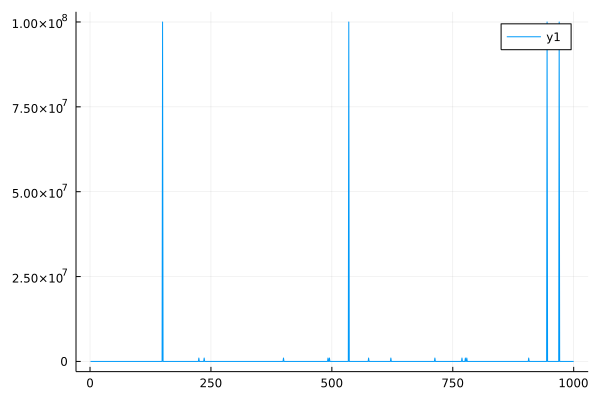

In [5]:
# 各エピソードにおける報酬は Plots.jl でプロット可能
using Plots

hook = TotalRewardPerEpisode()
run(
    RandomPolicy(action_space(env)),
    env,
    StopAfterEpisode(1_000),
    hook
)

plot(hook.rewards)

### 強化学習 環境ラッパーの追加
モンテカルロ法を用いてQ学習を行うために `QBasedPolicy(learner=MontecarloLearner)` で環境をラッピングする

In [6]:
using Flux: InvDecay

p = QBasedPolicy(;
    learner = MonteCarloLearner(;
        approximator = TabularQApproximator(;
            n_state = length(state_space(env)),
            n_action = length(action_space(env)),
            opt = InvDecay(1.0)
        )
    ),
    explorer = EpsilonGreedyExplorer(0.1)
)

typename(QBasedPolicy)
├─ learner => typename(MonteCarloLearner)
│  ├─ approximator => typename(TabularApproximator)
│  │  ├─ table => 3×2 Matrix{Float64}
│  │  └─ optimizer => typename(InvDecay)
│  │     ├─ gamma => 1.0
│  │     └─ state => typename(IdDict)
│  ├─ γ => 1.0
│  ├─ kind => typename(ReinforcementLearningZoo.FirstVisit)
│  └─ sampling => typename(ReinforcementLearningZoo.NoSampling)
└─ explorer => typename(EpsilonGreedyExplorer)
   ├─ ϵ_stable => 0.1
   ├─ ϵ_init => 1.0
   ├─ warmup_steps => 0
   ├─ decay_steps => 0
   ├─ step => 1
   ├─ rng => typename(Random._GLOBAL_RNG)
   └─ is_training => true


In [7]:
p(env)

LoadError: MethodError: no method matching (::TabularQApproximator{Matrix{Float64}, InvDecay})(::Bool)
[0mClosest candidates are:
[0m  (::TabularQApproximator)([91m::Int64[39m) at C:\Users\user\.julia\packages\ReinforcementLearningCore\s9XPF\src\policies\q_based_policies\learners\approximators\tabular_approximator.jl:47
[0m  (::TabularQApproximator)([91m::Int64[39m, [91m::Int64[39m) at C:\Users\user\.julia\packages\ReinforcementLearningCore\s9XPF\src\policies\q_based_policies\learners\approximators\tabular_approximator.jl:48

ここで、ラッピング環境でエラーが発生してしまう

この原因を考えてみる

まず、上記で定義した `QBasedPolicy` には `learner` と `explorer` の2つの部分が存在する

- `QBasedPolicy` の learner と explorer
    - **learner**:
        - `env` を実行しながら、状態に対する行動の価値を学習する関数 (Q関数)
            - 状態に対する行動の価値: Q値
    - **explorer**:
        - learner が算出したQ値をもとに、行動を選択する関数

ここで、learner に指定されている `MontecarloLearner` の中では、`TabularQApproximator` がQ値推定のために使用されている

しかし、`TabularQApproximator` は状態変数として `Int` 型しか受け付けないため、この部分でエラーが発生している

In [8]:
p.learner.approximator(1, 1) # Q(state::Int, action::Any)

0.0

In [9]:
p.learner.approximator(1) # [Q(state::Int, action::Any) for action in action_space(env)]

3-element view(::Matrix{Float64}, :, 1) with eltype Float64:
 0.0
 0.0
 0.0

In [ ]:
p.learner.approximator(false) # Q(state::Bool, action::Any) => Error! `state` is not Int.

LoadError: MethodError: no method matching (::TabularQApproximator{Matrix{Float64}, InvDecay})(::Bool)
[0mClosest candidates are:
[0m  (::TabularQApproximator)([91m::Int64[39m) at C:\Users\user\.julia\packages\ReinforcementLearningCore\s9XPF\src\policies\q_based_policies\learners\approximators\tabular_approximator.jl:47
[0m  (::TabularQApproximator)([91m::Int64[39m, [91m::Int64[39m) at C:\Users\user\.julia\packages\ReinforcementLearningCore\s9XPF\src\policies\q_based_policies\learners\approximators\tabular_approximator.jl:48

これでエラーの原因はわかった

これを直すためには `TabularQApproximator` に渡す状態変数を `Int` 型に変換すれば良い

一番わかり易いのは `RLBase.state(env::LetteryEnv)` 関数を書き直すことである

しかし ReinforcementLearning.jl では、ラッパー環境用に env を変換する手段として `ActionTransformedEnv` や `StateTrabsformedEnv` 関数が提供されているため、今回はこれを使ってみる

In [10]:
wrapped_env = StateTransformedEnv(
    # env の状態を Bool => Int に変換する
    # 状態空間を Base.OneTo 型に変換する
    env;
    state_mapping = state -> state ? 1 : 2, # 実行状態: 1, 終了状態: 2
    state_space_mapping = state_space -> Base.OneTo(2) # 状態空間: 2値なので Base.OneTo(2)
) |> env -> ActionTransformedEnv(
    # 行動空間を Base.OneTo 型に変換する
    env;
    action_mapping = index -> action_space(env)[index],
    action_space_mapping = action_space -> Base.OneTo(3) # :PowerRich, :MegaHaul, nothing の3値なので Base.OneTo(3)
)

# LotteryEnv |> StateTransformedEnv |> ActionTransformedEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

Yes

## State Space

`Base.OneTo(2)`

## Action Space

`Base.OneTo(3)`

## Current State

```
1
```


In [11]:
p(wrapped_env)

1

In [12]:
# Q学習実行
hook = TotalRewardPerEpisode()
run(
    p,
    wrapped_env,
    StopAfterEpisode(1_000),
    hook
)

                    ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
                    ┌────────────────────────────────────────┐ 
          100000000 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⢸⡇⡇⡇⠀⠀⠀⡇⠀⠀⢸⠀⢸⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀│ 
                    │⠀⠀⡇⠀⠀⠀⠀⠀⠀⢸⡇⡇⡇⠀⠀⠀⡇⠀⠀⢸⠀⢸⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀│ 
                    │⠀⠀⡇⠀⠀⠀⠀⠀⠀⢸⡇⡇⡇⠀⠀⠀⡇⠀⠀⢸⠀⢸⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀│ 
                    │⠀⠀⡇⠀⠀⠀⠀⠀⠀⢸⡇⡇⡇⠀⠀⠀⡇⠀⠀⢸⠀⣸⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀│ 
                    │⠀⠀⣿⠀⠀⠀⠀⠀⠀⢸⡇⡇⡇⠀⠀⠀⡇⠀⠀⢸⠀⣿⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀│ 
                    │⠀⠀⣿⠀⠀⠀⠀⠀⠀⢸⡇⡇⡇⠀⠀⠀⡇⠀⠀⢸⠀⣿⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀│ 
                    │⠀⠀⣿⠀⠀⠀⠀⠀⠀⢸⡇⡇⡇⠀⠀⠀⡇⠀⠀⢸⠀⣿⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀│ 
   Score            │⠤⠤⠿⠤⠤⠤⠤⠤⠤⠼⠧⠧⠧⠤⠤⠤⠧⠤⠤⠼⠤⠿⠧⠤⠧⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠿⠤⠤⠤⠤│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                    │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

TotalRewardPerEpisode([-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0  …  -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0], 0.0, true)

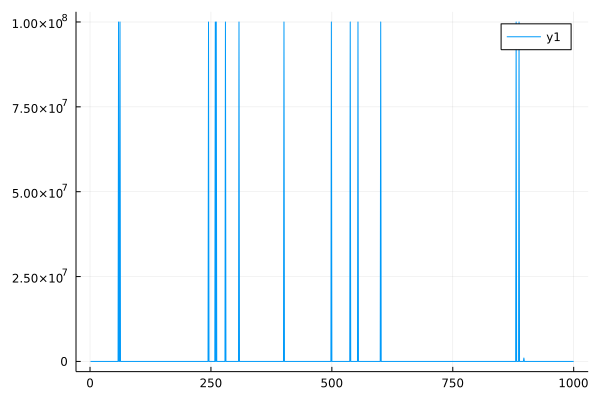

In [13]:
plot(hook.rewards)

これでQ学習の実行ができた

本来、合計報酬はエピソード回数を重ねるごとに右肩上がりになっていれば学習が上手く進行していることになる

しかし、上記の場合は右肩上がりにはなっていない

これは、Q学習 Policy がアクターモードのままになっているためである

Policy を学習モードで実行するためには `Agent` Policy を使う必要があるため、これを追加して完了である

In [14]:
# Q学習を学習モードで実行
hook = TotalRewardPerEpisode()
run(
    Agent(
        policy = p,
        
        # VectorSARTTrajectory: アクション, 報酬, 状態を保存する
        trajectory = VectorSARTTrajectory()
    ),
    wrapped_env,
    StopAfterEpisode(1_000),
    hook
)

             ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
             ┌────────────────────────────────────────┐ 
           0 │⣿⣿⣿⣿⣿⢹⡏⡏⠉⠉⢹⣿⣿⣿⣿⡏⢹⣿⠉⢹⣿⢹⣿⣿⢹⠉⡏⠉⠉⢹⡏⣿⡏⡏⡏⡏⢹⢹⡏⡏│ 
             │⣿⣿⣿⣿⣿⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⣿⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⣿⣿⣿⣿⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⣿⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⣿⣿⣿⣿⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⣿⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⣿⣿⣿⣿⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⣿⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⣿⣿⣿⣿⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⣿⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⣿⣿⣿⣿⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⣿⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
   Score     │⣿⡟⣿⣿⢿⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⡿⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⡇⣿⣿⢸⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⡇⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⡇⣿⣿⢸⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⡇⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⡇⣿⣿⢸⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⡇⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⡇⣿⣿⢸⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⡇⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⡇⣿⣿⢸⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⡇⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             │⣿⡇⣿⣿⢸⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⡇⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
         -10 │⣿⡇⣿⣿⢸⢸⡇⡇⠀⠀⢸⣿⣿⣿⣿⡇⢸⣿⠀⢸⣿⢸⡇⣿⢸⠀⡇⠀⠀⢸⡇⣿⡇⡇⡇⡇⢸⢸⡇⡇│ 
             └─────────────────

TotalRewardPerEpisode([-10.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.0, true)

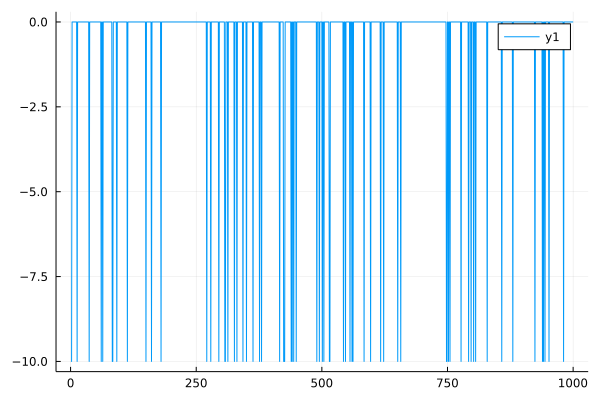

In [15]:
plot(hook.rewards)

学習の結果を見てみると、「何もしないのが最適解である」ということを学習しているように見える

実際、今回の LotteryEnv のような、運要素が強く、リターンの期待値も低いようなゲームは、何もしないのが一番報酬としては良くなる

そのため、学習は上手く行ったと言える